In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import cartopy.crs as crs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter  # For 0-360 longitude ticks
from cmocean import cm
import os 

from Functions import * 
from combine_data import *   # Loading models by namelist

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

# Data loading

In [2]:
merged_aus = read_data('','Australia')

Loading wam2layers data for Australia
Loading 2ldrm data for Australia
Loading utrack data for Australia
Loading btrims data for Australia
Skipping tracmass data for Australia - not available
Loading ughent data for Australia
Loading UIB data for Australia
Skipping UIB data for Australia - not available
Loading UniVie data for Australia
Loading CHc data for Australia
Loading xu data for Australia
Loading tatfancheng data for Australia
Loading uvigo data for Australia


In [10]:
for i, mn in enumerate(merged_aus.data_vars):
    print(i, mn)

0 WAM2layers
1 2LDRM
2 UTrack Ens1
3 UTrack Ens2
4 UTrack Ens3
5 UTrack Ens4
6 UTrack Ens5
7 B-TrIMS
8 FLEXPART-HAMSTER Ens1
9 FLEXPART-HAMSTER Ens2
10 FLEXPART-HAMSTER Ens3
11 FLEXPART-HAMSTER Ens4
12 FLEXPART-HAMSTER Ens5
13 FLEXPART-WaterSip (UniVie)
14 LAGRANTO-WaterSip (CHc)
15 FLEXPART-WaterSip (Xu)
16 FLEXPART-WaterSip (TFC) Ens1
17 FLEXPART-WaterSip (TFC) Ens2
18 FLEXPART-WaterSip (TFC) Ens3
19 FLEXPART-LATTIN (UVigo)
20 FLEXPART-Stohl (UVigo)


In [5]:
# Shift longitude from (-180,180) to (0,360)
merged_aus2 = merged_aus.copy()
merged_aus2.coords['lon'] = (merged_aus2.coords['lon'] + 360) % 360
merged_aus2 = merged_aus2.sortby(merged_aus2.lon)

In [6]:
# Unique model names
unique = ['WAM2layers',
          '2LDRM',
          'UTrack Ens1',
          'B-TrIMS',
          'FLEXPART-HAMSTER Ens5',
          'FLEXPART-WaterSip (UniVie)',
          'LAGRANTO-WaterSip (CHc)',
          'FLEXPART-WaterSip (Xu)',
          'FLEXPART-WaterSip (TFC) Ens1',
          'FLEXPART-Stohl (UVigo)',
         ]

# Sample plots

In [7]:
# Load mask
mask = xr.open_dataset('./Australia/mask_australia_box_lon0to360.nc')
maskr = mask.mask.isel(time=0).drop_vars('time')

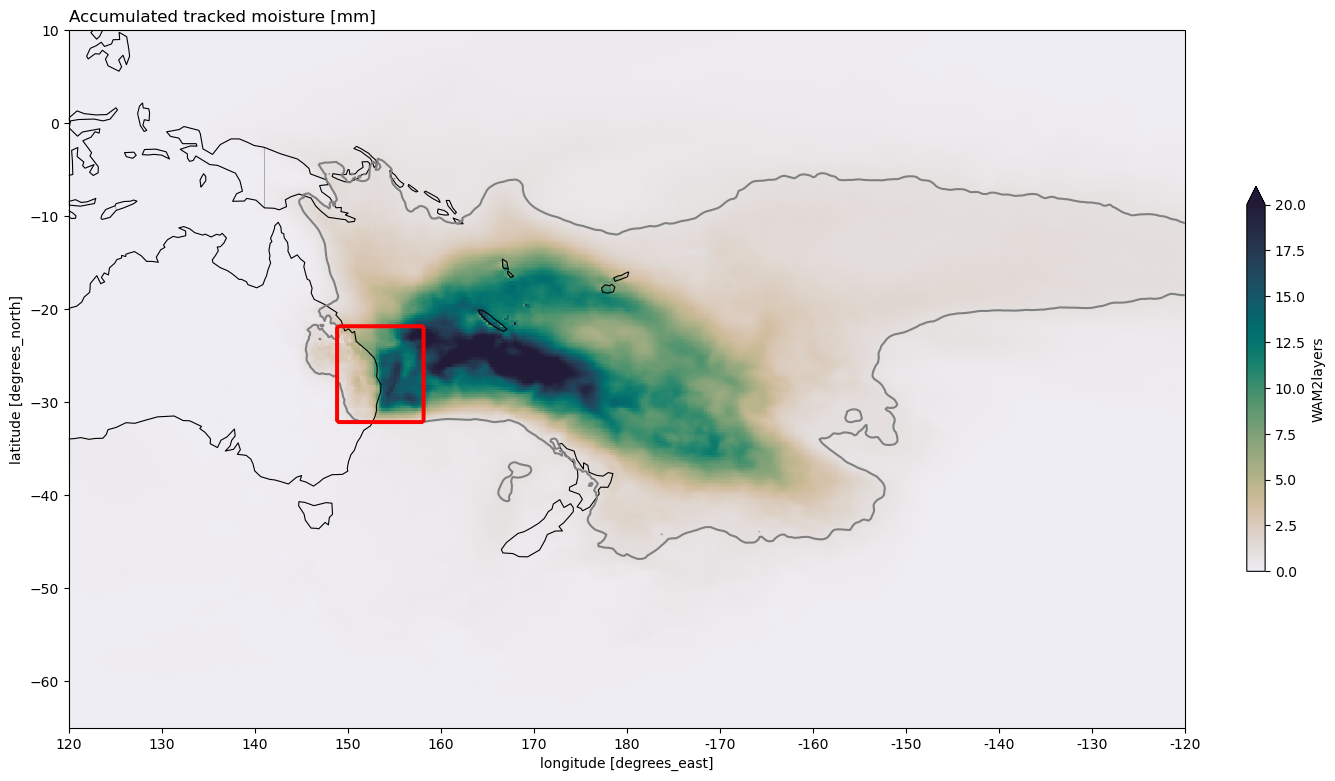

In [9]:
# Make sample figure (in this case of WAM2layers)
prj180 = crs.PlateCarree(central_longitude=180)
prj = crs.PlateCarree()

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=prj180)
ax.set_xticks(np.arange(0, 361, 10), crs=prj)
ax.set_yticks(np.arange(-90, 91, 10), crs=prj)
lon_formatter = LongitudeFormatter(direction_label=False, degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)

ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)

src = merged_aus2[unique[0]]  # WAM2layers for #3
src.plot(
        vmin=0, #Min source in mm
        vmax=20, #Max source in mm
        robust=False,
        cmap=cm.rain, #Colour map from cmocean package
        cbar_kwargs=dict(fraction=0.05, shrink=0.5),
        transform = prj
    )
src.plot.contour(ax=ax, levels=[1], colors=["grey"], transform = prj)
maskr.plot.contour(ax=ax, colors=['red'], transform = prj)
ax.set_title("Accumulated tracked moisture [mm]", loc="left")

ax.set_extent([120, 240, -65, 10], prj)

# plt.savefig("Wam2layers_sources_Australia.png")

## Uncorrected plot of moisture sources

### Using axis as an index

Drawing:  WAM2layers
Drawing:  2LDRM
Drawing:  UTrack Ens1
Drawing:  B-TrIMS
Drawing:  FLEXPART-HAMSTER Ens5
Drawing:  FLEXPART-WaterSip (UniVie)
Drawing:  LAGRANTO-WaterSip (CHc)
Drawing:  FLEXPART-WaterSip (Xu)
Drawing:  FLEXPART-WaterSip (TFC) Ens1
Drawing:  FLEXPART-Stohl (UVigo)
CPU times: user 2min 10s, sys: 4.32 s, total: 2min 15s
Wall time: 2min 8s


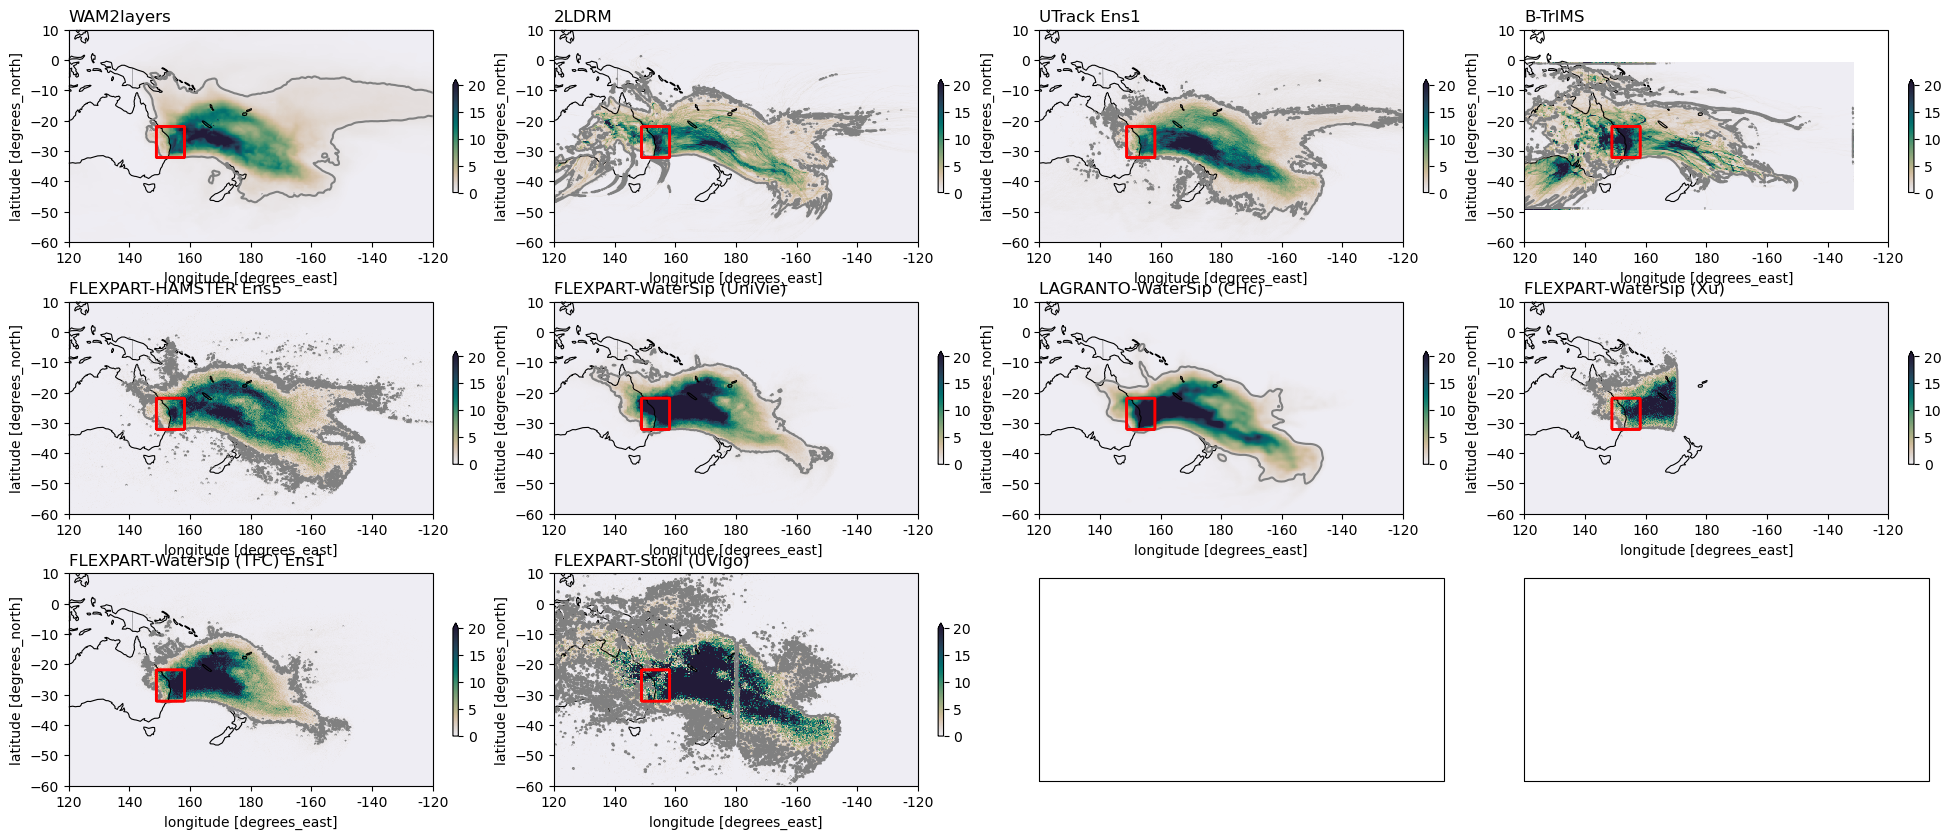

In [11]:
%%time
prj180 = crs.PlateCarree(central_longitude=180)
prj = crs.PlateCarree()

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(24, 10), subplot_kw={'projection': prj180})

for i, ax in enumerate(fig.axes):  
    if i >= len(unique):
        continue
        
    ttl = unique[i]               # bring the label of the model
    src = merged_aus2[unique[i]]  # and the result of the selected model
    
    ax.set_xticks(np.arange(0, 361, 20), crs=prj)   # Setting xticks (0,360)
    ax.set_yticks(np.arange(-90, 91, 10), crs=prj)  # Setting yticks (-90,90)
    lon_formatter = LongitudeFormatter(direction_label=False, degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
        
    src.plot(ax=ax, cmap=cm.rain, vmin=0, vmax=20,
             cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
             transform = crs.PlateCarree(),)
    src.plot.contour(ax=ax, levels=[1], colors=["grey"], transform = prj)
    maskr.plot.contour(ax=ax, colors=['red'], transform = prj)
    ax.set_title(ttl, loc='left')
    ax.set_extent([120, 240, -60, 10], prj)
    print('Drawing: ', ttl)

fig.savefig("MoistureSources_Australia_reduced.png",dpi=300)

### Using model name as an index

Drawing:  WAM2layers
Drawing:  2LDRM
Drawing:  UTrack Ens1
Drawing:  B-TrIMS
Drawing:  FLEXPART-HAMSTER Ens5
Drawing:  FLEXPART-WaterSip (UniVie)
Drawing:  LAGRANTO-WaterSip (CHc)
Drawing:  FLEXPART-WaterSip (Xu)
Drawing:  FLEXPART-WaterSip (TFC) Ens1
Drawing:  FLEXPART-Stohl (UVigo)
CPU times: user 2min 5s, sys: 3.87 s, total: 2min 8s
Wall time: 2min 2s


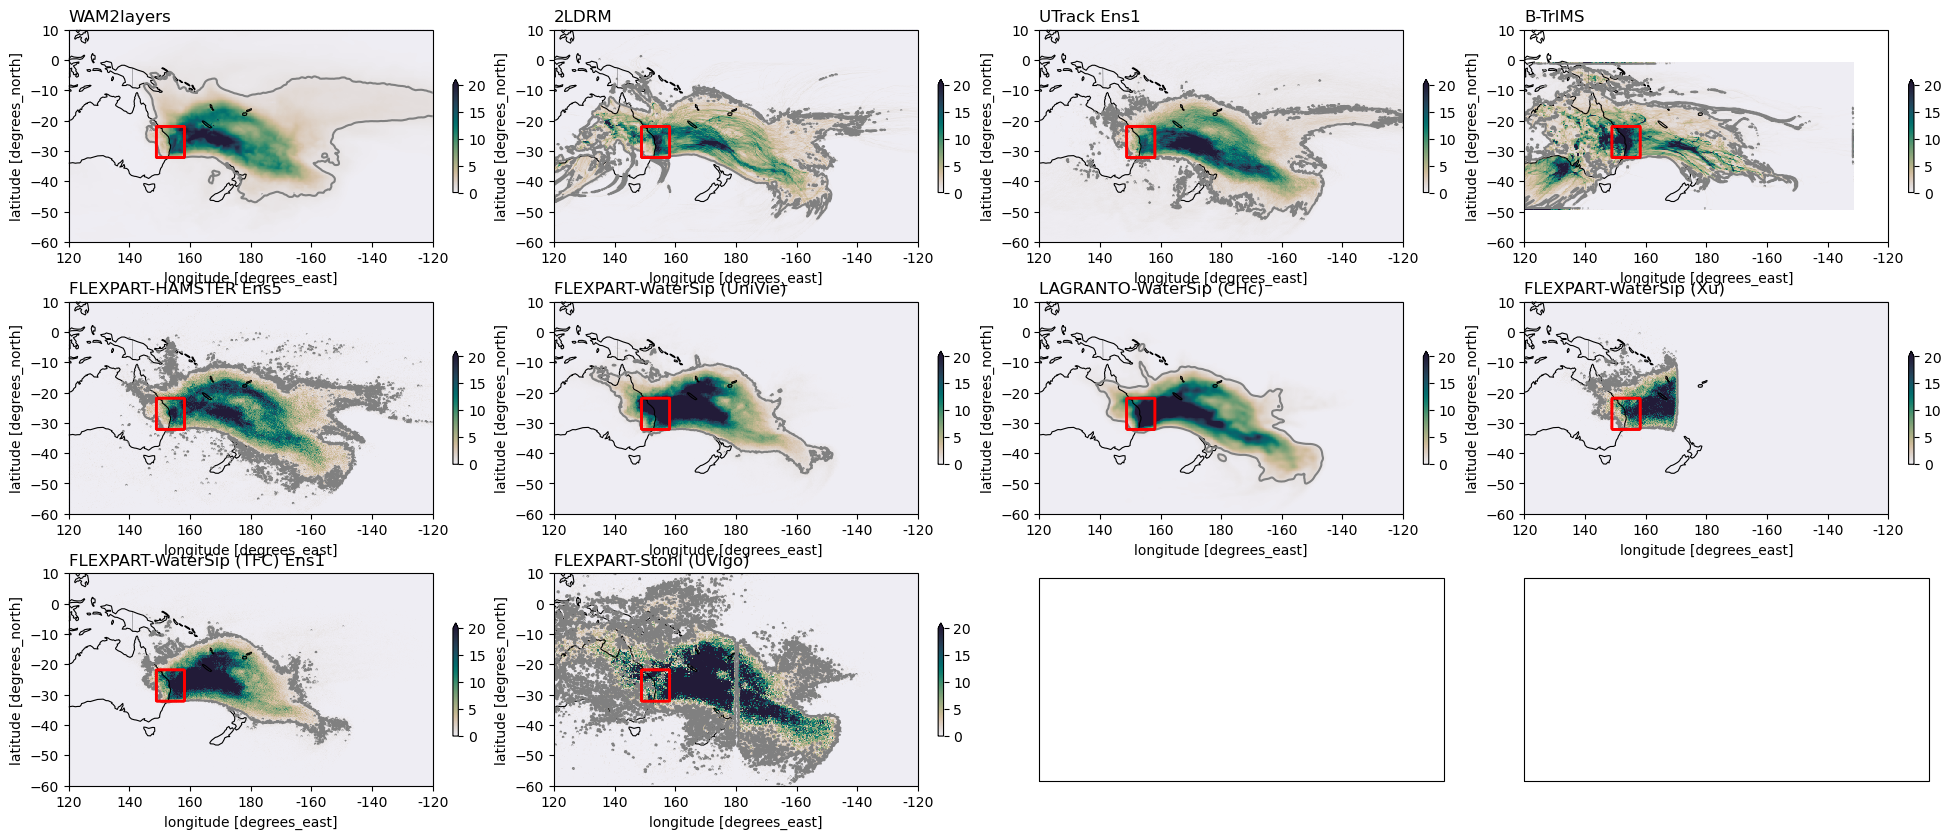

In [22]:
%%time
prj180 = crs.PlateCarree(central_longitude=180)
prj = crs.PlateCarree()

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(24, 10), subplot_kw={'projection': prj180})

subi = -1
for i, (name, data) in enumerate(merged_aus2.data_vars.items()):
    if name not in unique:
        continue
    else:
        subi += 1 
    
    ax = axs.flatten()[subi]
    data.plot(ax=ax, cmap=cm.rain, vmin=0, vmax=20,
              cbar_kwargs=dict(fraction=0.05, shrink=0.5,label=None),
              transform = crs.PlateCarree())
    ax.set_title(name, loc='left')
    data.plot.contour(ax=ax, levels=[1], colors=["grey"], transform = prj)
    maskr.plot.contour(ax=ax, colors=['red'], transform = prj)
    
    ax.set_xticks(np.arange(0, 361, 20), crs=prj)   # Setting xticks (0,360)
    ax.set_yticks(np.arange(-90, 91, 10), crs=prj)  # Setting yticks (-90,90)
    lon_formatter = LongitudeFormatter(direction_label=False, degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
    ax.set_extent([120, 240, -60, 10], prj)
    print('Drawing: ', name)

fig.savefig("MoistureSources_Australia_reduced2.png",dpi=300)